<a href="https://colab.research.google.com/github/Rasamps/drug-misuse/blob/master/mixed_data_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
df = pd.read_csv('drug_cons_data.csv', header = 0)
selected_feats = df.filter(items = ['Ascore','Cscore','Escore','Nscore','Oscore','Cann','Nico'])

drugset = df.filter(items = ["Alc","Amph","Amyl","Benz","Caff","Choc","Coke","Crack","Ect",
        "Heroin","Keta","Legalh","LSD","Meth","Shrooms","Semer","VSA"])

print(selected_feats.head())
print(selected_feats.columns)

    Ascore   Cscore   Escore   Nscore   Oscore Cann Nico
0 -0.91699 -0.00665 -0.57545  0.31287 -0.58331  CL0  CL2
1  0.76096 -0.14277  1.93886 -0.67825  1.43533  CL4  CL4
2 -1.62090 -1.01450  0.80523 -0.46725 -0.84732  CL3  CL0
3  0.59042  0.58489 -0.80615 -0.14882 -0.01928  CL2  CL2
4 -0.30172  1.30612 -1.63340  0.73545 -0.45174  CL3  CL2
Index(['Ascore', 'Cscore', 'Escore', 'Nscore', 'Oscore', 'Cann', 'Nico'], dtype='object')


Plot the features pairwise to get insights into the data.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



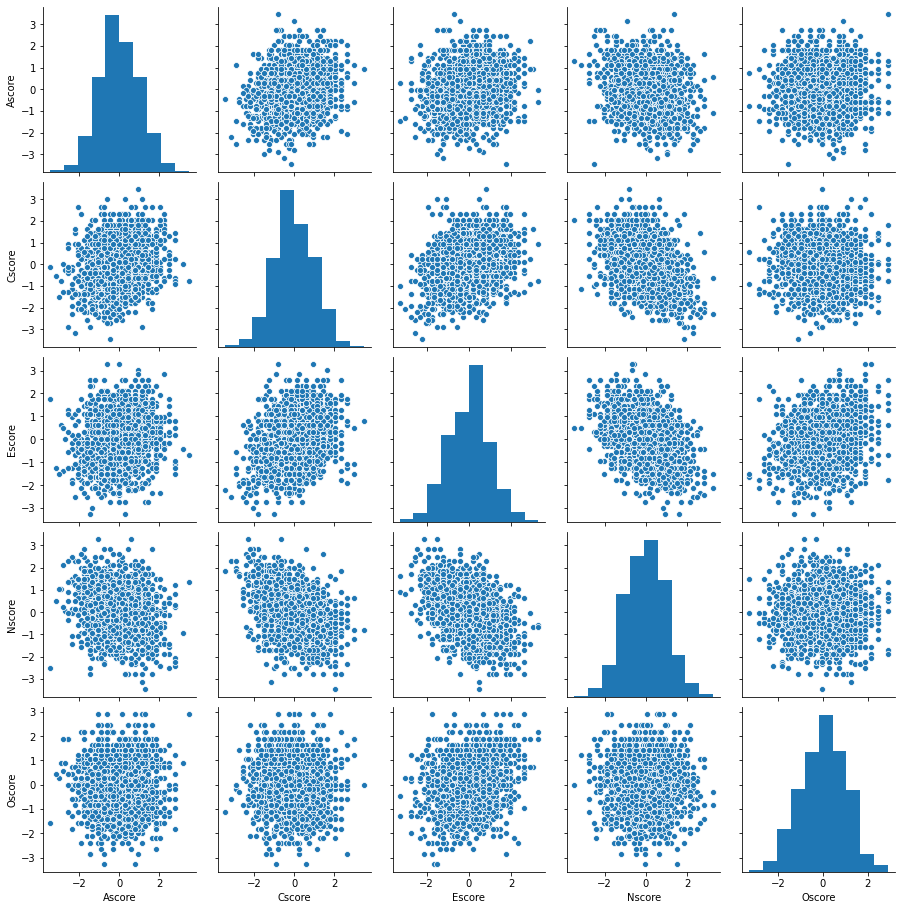

In [3]:
import seaborn as sns

scatter = sns.pairplot(selected_feats)

Based on the plots we can see that the Escore and Cscore variables provide a near identical distribution and have negated correlations of one another with the rest of the variables.

In [4]:
selected_feats = selected_feats.drop('Escore', axis = 'columns')
selected_feats.head()

,Ascore,Cscore,Nscore,Oscore,Cann,Nico
0,-0.91699,-0.00665,0.31287,-0.58331,CL0,CL2
1,0.76096,-0.14277,-0.67825,1.43533,CL4,CL4
2,-1.62090,-1.01450,-0.46725,-0.84732,CL3,CL0
3,0.59042,0.58489,-0.14882,-0.01928,CL2,CL2
4,-0.30172,1.30612,0.73545,-0.45174,CL3,CL2


In [5]:
!pip install prince

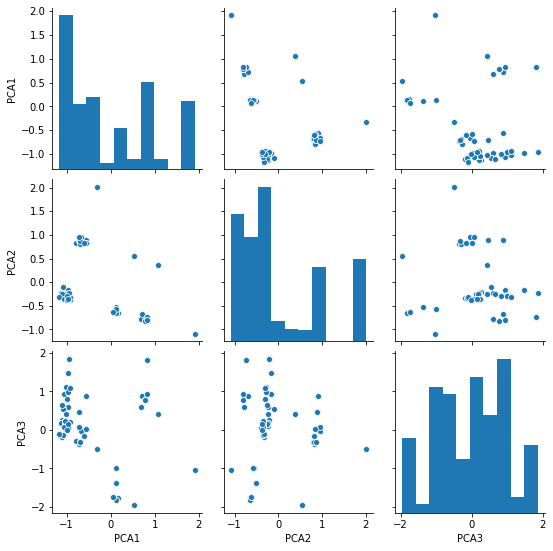

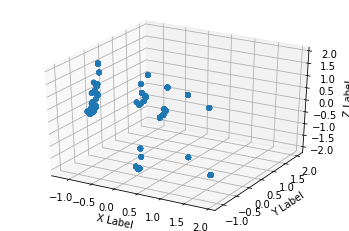

In [6]:
import prince
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

famd = prince.FAMD(n_components = 3,
                   n_iter = 5,
                   copy = True,
                   check_input = True,
                   engine = 'auto')
famd = famd.fit(selected_feats)
reduced_data = famd.row_coordinates(selected_feats)

scaler = StandardScaler()
reduced_data = scaler.fit_transform(reduced_data)
reduced_data = pd.DataFrame({'PCA1': reduced_data[:,0], 'PCA2': reduced_data[:, 1], 'PCA3': reduced_data[:, 2]})

scatter = sns.pairplot(reduced_data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_data['PCA1'], reduced_data['PCA2'], reduced_data['PCA3'], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

The K-Means clustering step will require two separate scripts:
One for finding the optimal k, the other for plotting those clusters as colour upon the pca data.

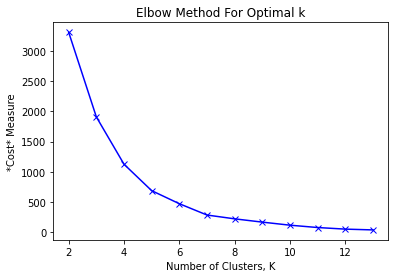

In [7]:
#Try K-Means Clustering
from sklearn.cluster import KMeans
costs = []
k_clusters = range(2,14)
for k in k_clusters:
  km = KMeans(n_clusters = k)
  km = km.fit(reduced_data)
  costs.append(km.inertia_)
plt.plot(k_clusters, costs, 'bx-')
plt.xlabel('Number of Clusters, K')
plt.ylabel('*Cost* Measure')
plt.title('Elbow Method For Optimal k')
plt.show()

Select 3 clusters

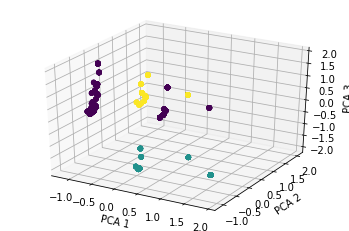

In [8]:
final_kmean_model = KMeans(n_clusters = 3)
kmean_results = final_kmean_model.fit(reduced_data)
clusters = kmean_results.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_data['PCA1'], reduced_data['PCA2'], reduced_data['PCA3'], c = clusters, marker='o')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

Next try an hierarchical approach.

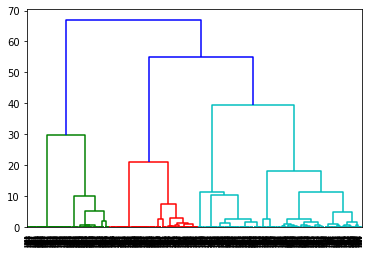

In [9]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(reduced_data, method='ward'))

From this we can assert that three clusters may be appropriate.

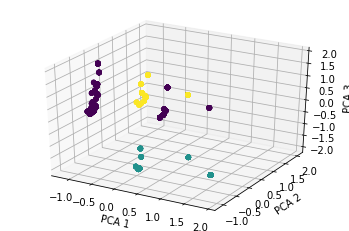

In [10]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 3, affinity='euclidean', linkage='ward')
hier_results = model.fit(reduced_data)
clusters = hier_results.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_data['PCA1'], reduced_data['PCA2'], reduced_data['PCA3'], c = clusters, marker='o')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

We see the result from hierarchical tends to follow a similar clustering scheme as kmeans... Retrying with 5 clusters may give the same results as kmeans!

Lastly, attempt a density based approach to get one last consideration

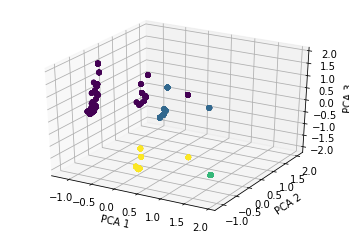

In [11]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.4, min_samples = 3)
dbscan_results = dbscan.fit(reduced_data)

clusters = dbscan_results.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_data['PCA1'], reduced_data['PCA2'], reduced_data['PCA3'], c = clusters, marker='o')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

We see from the sparseness of the data that a density based approach almost gives an identical clustering to K-means and Hierarchical. Although the sparseness does encourage a couple outliers.

Begin by re-plotting the original data with the clusters over top.

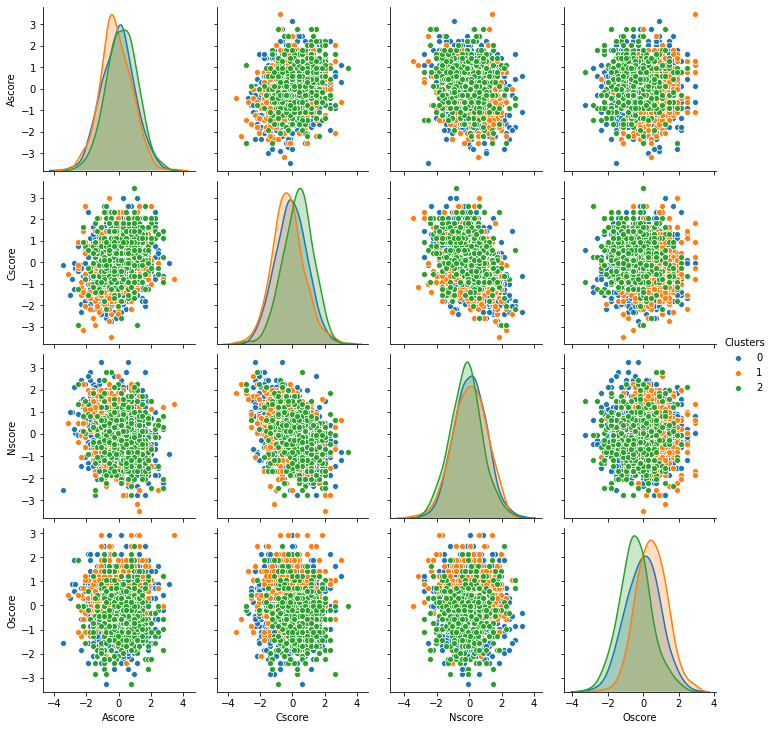

In [12]:
cluster_frame = pd.DataFrame({'Clusters': kmean_results.labels_})
num_with_clusters = pd.concat((cluster_frame,
                              selected_feats.filter(items=['Ascore','Cscore','Nscore','Oscore'])),
                              axis = 1)
cat_with_clusters = pd.concat((cluster_frame,
                              selected_feats.filter(items=['Cann','Nico'])),
                              axis = 1)
cat_with_clusters.head()
num_with_clusters.head()

scatter = sns.pairplot(num_with_clusters, hue = 'Clusters')

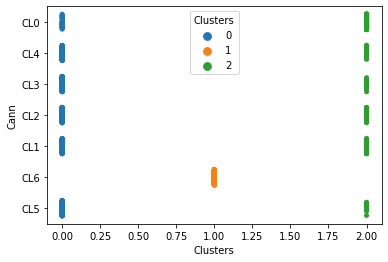

In [13]:
stripplot = sns.stripplot(y = 'Cann', x = 'Clusters', data = cat_with_clusters, hue = 'Clusters', jitter = 0.25)

Implies that Cluster 1 corresponds to frequent use.

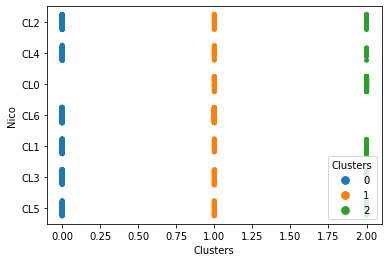

In [14]:
stripplot = sns.stripplot(y = 'Nico', x = 'Clusters', data = cat_with_clusters, hue = 'Clusters', jitter = 0.25)

For nicotine the clusters within the data seem rather evenly dispersed which makes it harder to glean more information about our clusters from this figure.

Look at the mean of the different clusters with respect to the features we have.

In [16]:
import plotly.express as px
summarized_data = num_with_clusters.groupby(by = 'Clusters', axis = 0).mean()
summarized_data.head()
p0 = pd.DataFrame([['Ascore',0.213208],['Cscore',0.349281],['Nscore',-0.185199],['Oscore',-0.429280]],
                  columns = ['Score','Mean Value'])
p1 = pd.DataFrame([['Ascore',-0.164909],['Cscore',-0.262044],['Nscore',0.051772],['Oscore',0.481055]],
                  columns = ['Score','Mean Value'])
p2 = pd.DataFrame([['Ascore',-0.033579],['Cscore',-0.059056],['Nscore',0.074812],['Oscore',-0.009410]],
                  columns = ['Score','Mean Value'])

fig0 = px.line_polar(p0, r='Mean Value', theta='Score', line_close=True)
fig0.show()

In [17]:
fig1 = px.line_polar(p1, r='Mean Value', theta='Score', line_close=True)
fig1.show()

In [18]:
fig2 = px.line_polar(p2, r='Mean Value', theta='Score', line_close=True)
fig2.show()

From these three spider plots, we can see that each cluster is characterized by the personality scores in a different way.

<BarContainer object of 7 artists>

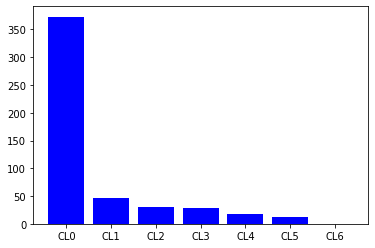

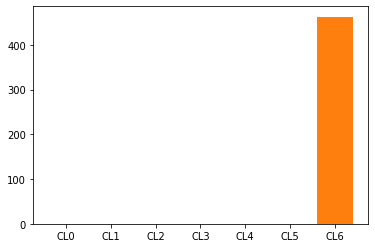

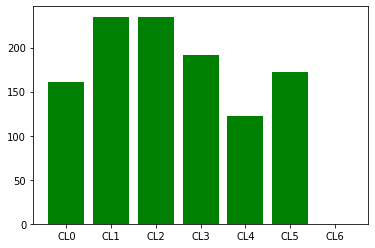

In [0]:
cann_cluster0 = pd.DataFrame(data=[['CL0',373],['CL1',46],['CL2',31],['CL3',29],
                         ['CL4',18],['CL5',13],['CL6',0]],
                         index = ['Cluster 0']*7,
                   columns = ['Recently Used', '# Of Occurences'])
cann_cluster1 = pd.DataFrame(data=[['CL0',0],['CL1',0],['CL2',0],['CL3',0],
                         ['CL4',0],['CL5',0],['CL6',463]],
                         index = ['Cluster 1']*7,
                         columns = ['Recently Used', '# Of Occurences'])
cann_cluster2 = pd.DataFrame(data=[['CL0',161],['CL1',235],['CL2',235],['CL3',191],
                         ['CL4',122],['CL5',172],['CL6',0]],
                         index = ['Cluster 2']*7,
                         columns = ['Recently Used', '# Of Occurences'])
plt.figure()
plt.bar(cann_cluster0['Recently Used'], height = cann_cluster0['# Of Occurences'], color = 'b')
plt.figure()
plt.bar(cann_cluster1['Recently Used'], height = cann_cluster1['# Of Occurences'], color = 'C1')
plt.figure()
plt.bar(cann_cluster2['Recently Used'], height = cann_cluster2['# Of Occurences'], color = 'g')

We see that the clusters can be partitioned based on usage of cannabis.

<BarContainer object of 7 artists>

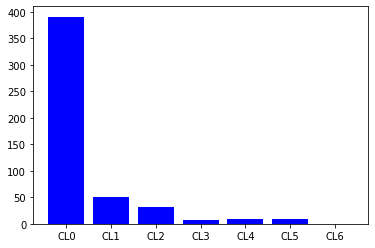

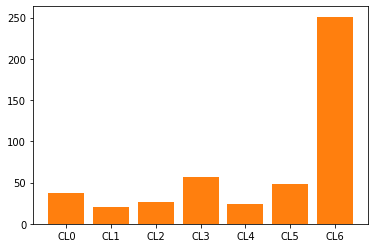

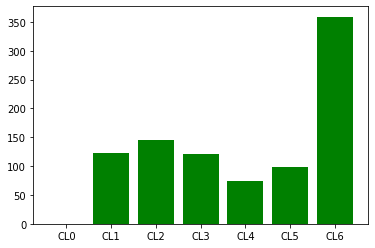

In [0]:
nico_cluster0 = pd.DataFrame(data=[['CL0',391],['CL1',51],['CL2',32],['CL3',7],
                         ['CL4',10],['CL5',10],['CL6',0]],
                         index = ['Cluster 0']*7,
                   columns = ['Recently Used', '# Of Occurences'])
nico_cluster1 = pd.DataFrame(data=[['CL0',37],['CL1',20],['CL2',26],['CL3',57],
                         ['CL4',24],['CL5',48],['CL6',251]],
                         index = ['Cluster 1']*7,
                         columns = ['Recently Used', '# Of Occurences'])
nico_cluster2 = pd.DataFrame(data=[['CL0',0],['CL1',122],['CL2',146],['CL3',121],
                         ['CL4',74],['CL5',99],['CL6',359]],
                         index = ['Cluster 2']*7,
                         columns = ['Recently Used', '# Of Occurences'])
plt.figure()
plt.bar(nico_cluster0['Recently Used'], height = nico_cluster0['# Of Occurences'], color = 'b')
plt.figure()
plt.bar(nico_cluster1['Recently Used'], height = nico_cluster1['# Of Occurences'], color = 'C1')
plt.figure()
plt.bar(nico_cluster2['Recently Used'], height = nico_cluster2['# Of Occurences'], color = 'g')

And that the first cluster is described by low nicotine usage, the second by very frequent nicotine usage and the third cluster by moderate to high nicotine usage.

Based on our knowledge of what defines each cluster we can now compare with the leftout features to see any correlation between cluster definition and labels of left out drugs.
A correlation here would provide researchers further grounds for exploration.

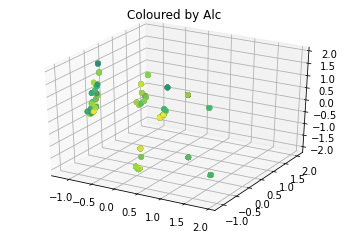

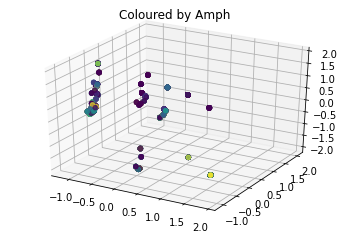

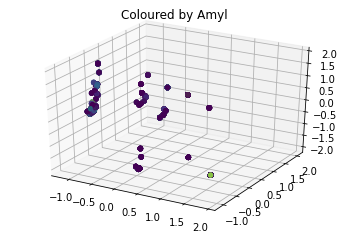

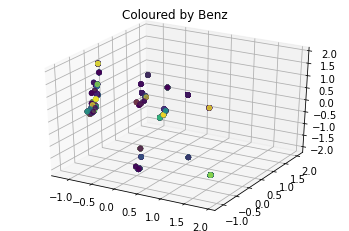

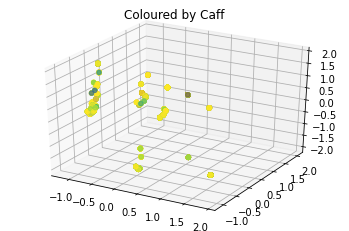

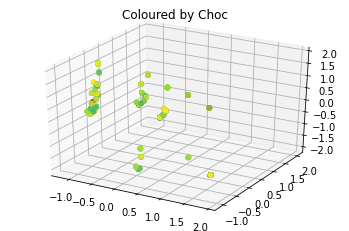

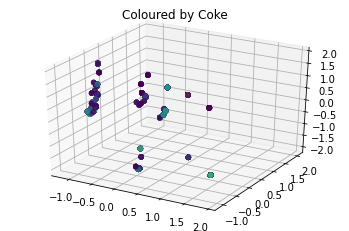

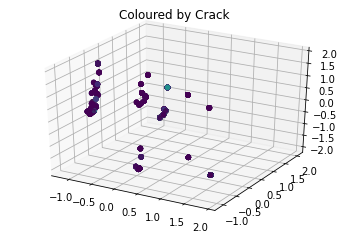

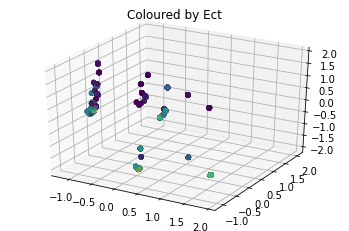

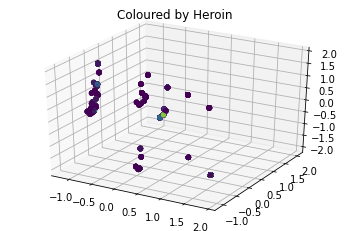

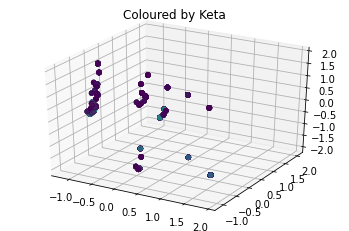

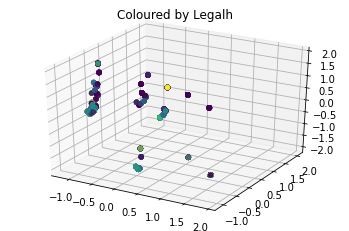

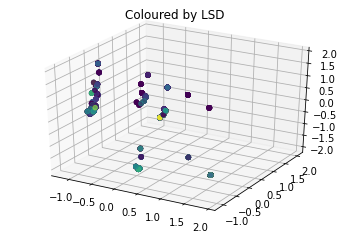

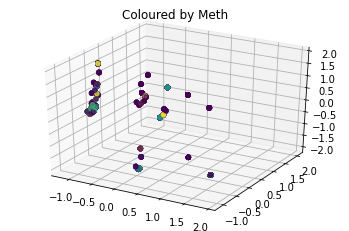

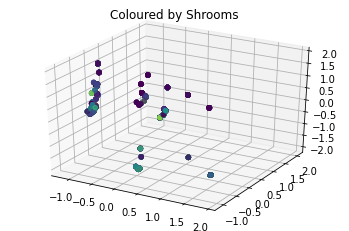

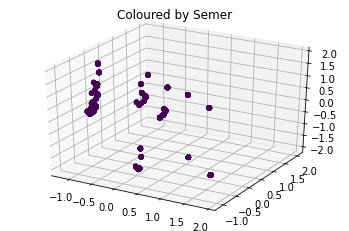

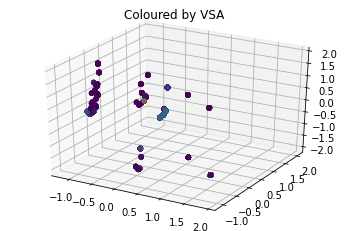

In [23]:
from sklearn.preprocessing import LabelEncoder

check_drugs = pd.concat((cluster_frame,reduced_data,drugset),axis = 1)
check_drugs.head()

le = LabelEncoder()

for drug in drugset.columns:
  check_drugs[drug] = le.fit_transform(check_drugs[drug])

for drug in drugset.columns:
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(check_drugs['PCA1'], check_drugs['PCA2'], check_drugs['PCA3'],
             c = check_drugs[drug], marker='o')
  ax.set_title('Coloured by '+drug)
  plt.show()


From these colourings we see that none of them align particularly well based on usage with the clusters we discovered.

Some drugs which do provide interesting results that could be worthwhile exploring further are:

Amph / Coke / LSD / Ect